In [1]:
### the original file was located at: /expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/Fragile_X
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import ttest_ind

In [2]:
dir_fig = 'fragile_x/'

In [3]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff
    
aff_dict_asd = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected_ASD'].tolist()):
    aff_dict_asd[sample] = aff

In [4]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

#this_sample = 'REACH000520'
#this_sample = 'REACH000290'
#this_sample = 'REACH000236_PB'
#print(df_cov[df_cov.SAMPLE == this_sample]['COHORT'].values)
#this_plat = get_plat(this_sample)
#print(this_plat)
#print(df_cov)

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [5]:
#file_in = 'FX_genotypes_famID_trim.txt'
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/Fragile_X/FX_genotypes_famID.txt'
col_names = ["Sample_id", "GB", "Z", "Qual", "Fam_id", "sex", "rel"]
col_names_dict = {i: col_names[i] for i in range(len(col_names))}

df = pd.read_table(file_in, sep='\t', header=None, keep_default_na=False)
df = df.rename(columns=col_names_dict)
df = df.loc[df.Sample_id.str.contains('REACH000')]

# the reference has 60bp or 20 repeats: chrX:147912051-147912110
df['GB_min'] = [min([int(y) for y in x.split('|')]) if x!='.' else '.' for x in df.GB]
df['GB_max'] = [max([int(y) for y in x.split('|')]) if x!='.' else '.' for x in df.GB]
df['repeats_min'] = [20 + int(int(x)/3) if x != '.' else '.' for x in df.GB_min]
df['repeats_max'] = [20 + int(int(x)/3) if x != '.' else '.' for x in df.GB_max]
df['Affected'] = [aff_dict[sample] for sample in df.Sample_id]
df['Platform'] = [plat_dict[sample] for sample in df.Sample_id]
#pd.set_option('display.max_rows', None)
display(df)

file_name = f'{dir_fig}/FMR1_repeat_gts.tsv'
print(file_name)
df.to_csv(file_name, sep='\t', header=True, index=False)

,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
1,REACH000001,29|31,0.20|0.32,0.99,F0001,1,C,29,31,29,30,Yes,ONT
2,REACH000107,0|34,-1.64|0.51,1,F0001,2,P,0,34,20,31,Yes,ONT
3,REACH000226,0|4,-1.64|-1.38,1,F0001,1,P,0,4,20,21,Yes,ONT
4,REACH000026,.,.,.,F0026,1,C,.,.,.,.,Yes,PB
5,REACH000269,.,.,.,F0026,2,P,.,.,.,.,No,PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,REACH000766,.,.,.,F0290,2,C,.,.,.,.,No,PB
269,REACH000767,30|30,0.26|0.26,0.88,F0291,1,C,30,30,30,30,Yes,PB
270,REACH000768,.,.,.,F0291,2,P,.,.,.,.,No,PB
271,REACH000769,27|27,0.07|0.07,0.48,F0291,1,P,27,27,29,29,No,PB


fragile_x//FMR1_repeat_gts.tsv


In [6]:
df_m = df.loc[(df.sex==1)&(df.GB!=".")].copy()
df_f = df.loc[(df.sex==2)&(df.GB!=".")].copy()
print(f'Num males: {df_m.shape[0]}')
print(f'Num females: {df_f.shape[0]}')
#pd.set_option('display.max_rows', None)
df_m['repeat_hp'] = ((df_m.repeats_min + df_m.repeats_max)/2).astype(int)
df_f_1 = df_f.copy()
df_f_1['repeat_hp'] = df_f_1.repeats_min
df_f_2 = df_f.copy()
df_f_2['repeat_hp'] = df_f_2.repeats_max

df_fm_hp = pd.concat([df_m, df_f_1, df_f_2])
print(f'Number of male/female haplotypes: {df_fm_hp.shape[0]}')
#display(df_fm_hp)


Num males: 95
Num females: 86
Number of male/female haplotypes: 267


fragile_x//dist_repeats_FX_hps.png


<Figure size 640x480 with 0 Axes>

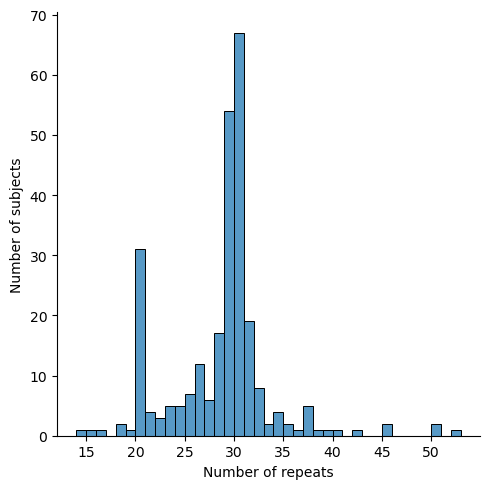

fragile_x//dist_repeats_FX_hps_PB.png


<Figure size 640x480 with 0 Axes>

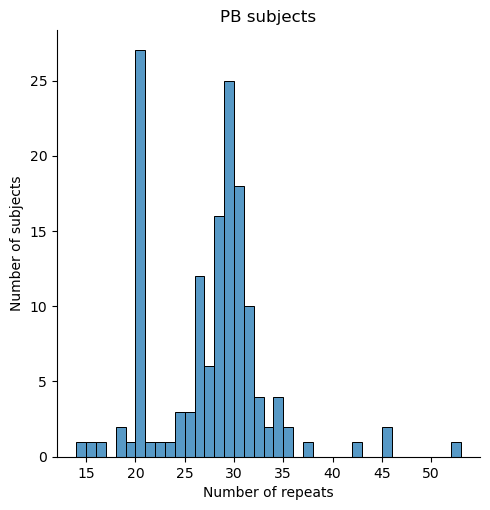

fragile_x//dist_repeats_FX_hps_ONT.png


<Figure size 640x480 with 0 Axes>

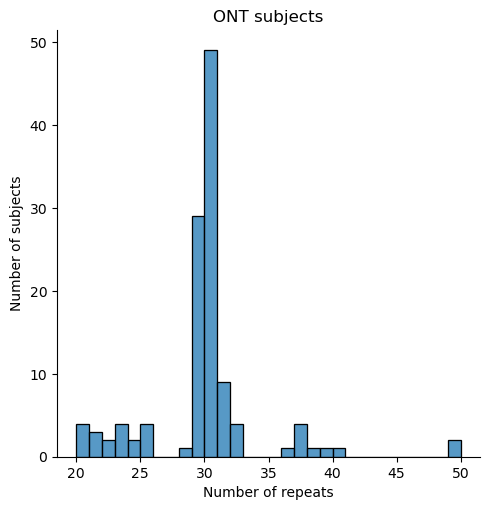

In [10]:
#df_flt = df.loc[df.HP_1!='.']

plt.figure()
sb.displot(data=df_fm_hp, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

### PB subjects
df_flt = df_fm_hp.loc[df_fm_hp.Platform!='PB']

plt.figure()
sb.displot(data=df_flt, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
plt.title('PB subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps_PB.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

### ONT subjects
df_flt = df_fm_hp.loc[df_fm_hp.Platform!='ONT']

plt.figure()
sb.displot(data=df_flt, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
plt.title('ONT subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps_ONT.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

/scratch/smmortazavi/job_36192620/ipykernel_1988544/3071905325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.boxplot(data=df_flt, x='Affected', y='repeats_max', boxprops={'alpha': 0.5}, fliersize=0, palette=['red', 'blue'], width=0.4)


fragile_x//case_control_repeat_num.png


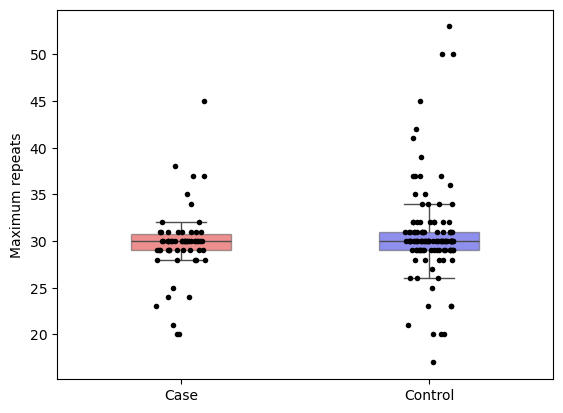

In [11]:
df_flt = df.loc[df.GB!="."].copy()
df_flt['Affected'] = ['Case' if x == 'Yes' else 'Control' for x in df_flt.Affected]
#display(df_flt)

plt.figure()
ax = sb.boxplot(data=df_flt, x='Affected', y='repeats_max', boxprops={'alpha': 0.5}, fliersize=0, palette=['red', 'blue'], width=0.4)
sb.stripplot(data=df_flt, x='Affected', y='repeats_max', ax=ax, legend=False, color='k', size=4)

plt.xlabel('')
plt.ylabel('Maximum repeats')
fig_name = f'{dir_fig}/case_control_repeat_num.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
df_flt_look = df.loc[df.GB!='.'].copy()
df_flt_look['GB_max'] = df_flt_look['GB_max'].astype(int)
df_flt_look = df_flt_look.loc[df_flt_look.GB_max>70]
df_flt_look_fam = df.loc[df.Fam_id.isin(df_flt_look.Fam_id)]
display(df_flt_look)
display(df_flt_look_fam)

,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
127,REACH000451,27|90,0.07|4.05,1,F0213,2,P,27,90,29,50,No,PB
129,REACH000453,33|91,0.45|4.11,1,F0213,2,C,33,91,31,50,No,PB
155,REACH000519,0|75,-1.64|3.10,1,F0230,2,C,0,75,20,45,No,ONT
181,REACH000560,77|77,3.23|3.23,0.25,F0241,1,C,77,77,45,45,Yes,ONT
184,REACH000563,18|101,-0.50|4.74,1,F0241,2,C,18,101,26,53,No,ONT


,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
126,REACH000450,.,.,.,F0213,2,C,.,.,.,.,No,PB
127,REACH000451,27|90,0.07|4.05,1,F0213,2,P,27,90,29,50,No,PB
128,REACH000452,.,.,.,F0213,1,P,.,.,.,.,No,PB
129,REACH000453,33|91,0.45|4.11,1,F0213,2,C,33,91,31,50,No,PB
154,REACH000518,20|28,-0.37|0.13,0.97,F0230,2,C,20,28,26,29,No,ONT
155,REACH000519,0|75,-1.64|3.10,1,F0230,2,C,0,75,20,45,No,ONT
156,REACH000523,20|28,-0.37|0.13,1,F0230,2,P,20,28,26,29,No,ONT
157,REACH000524,52|52,1.65|1.65,0.33,F0230,1,P,52,52,37,37,No,ONT
181,REACH000560,77|77,3.23|3.23,0.25,F0241,1,C,77,77,45,45,Yes,ONT
182,REACH000561,29|67,0.20|2.60,1,F0241,2,P,29,67,29,42,No,ONT


,Subject,haplotype,base pair deviation,repeats
0,"REACH000563 (child, F)",HP1,13,24
1,"REACH000563 (child, F)",HP1,24,28
2,"REACH000563 (child, F)",HP2,83,47
3,"REACH000563 (child, F)",HP2,100,53
4,"REACH000563 (child, F)",HP2,81,47
5,"REACH000563 (child, F)",HP2,95,51
6,"REACH000563 (child, F)",HP2,81,47
0,REACH000561 (mother),HP1,31,30
1,REACH000561 (mother),HP1,34,31
2,REACH000561 (mother),HP1,17,25


p_value: 0.007097771066893003
fragile_x//denovo_FX_REACH000563_repeats.png


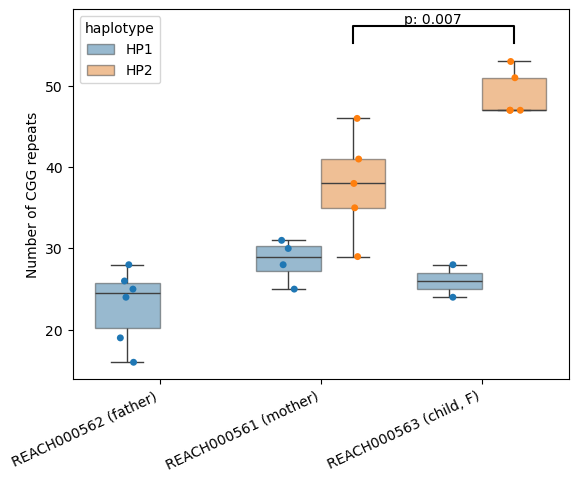

In [17]:
### F0241 family
# REACH000563: all reads are unphased
### NOTE: We identified a SNV comming from mother's haplotype at chrX:147,910,104 and the three reads in the child with that SNV. Two of those could be genotyped with snoopsv
###       and showed 81 and 95 base pair more than reference. So we can conclude that the longer repeat length is coming from the mother.
c_hp_all = [83,100,81,13,95,24,81]
c1_hp_2 = [83,100,81,95,81]
c1_hp_1 = [13,24]

# REACH000560: all reads are unphased, but he is male so it's on HP1
c2_hp_1 = [75]

# REACH000561 (mom): reads are phased
#m_hp_1 = [31,46,34,17,26]
#m_hp_2 = [79,55,28,65]

### correct a misplaced HP read:
m_hp_1 = [31,34,17,26]
m_hp_2 = [79,55,28,65,46]

# REACH000562 (dad): reads are all unphased but we have just one haplotype here
d_hp_all = [-10,12,20,-1,15,25]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000563 (child, F)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000560 (proband, M)' for x in range(len(c2_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]), 
                         'base pair deviation': c2_hp_1})
df_plt_m = pd.DataFrame({'Subject': ['REACH000561 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000562 (father)' for x in range(len(d_hp_all))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_all))]), 
                         'base pair deviation': d_hp_all})
#display(df_plt_c)
#display(df_plt_m)
#display(df_plt_d)

#order = ['REACH000560 (proband, M)', 'REACH000563 (sibling, F)', 'REACH000561 (mother)', 'REACH000562 (father)']
order = ['REACH000562 (father)', 'REACH000561 (mother)', 'REACH000563 (child, F)']

#df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt = pd.concat([df_plt_c1, df_plt_m, df_plt_d])

df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
display(df_plt)

plt.figure()
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5}, order=order)
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False, order=order)

# statistical annotation, Perform paired t-test
rep_mom_hp2 = df_plt.loc[(df_plt.Subject=='REACH000561 (mother)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
rep_sib_hp2 = df_plt.loc[(df_plt.Subject=='REACH000563 (child, F)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
#print(f'rep_mom_hp2: {rep_mom_hp2}')
#print(f'rep_sib_hp2: {rep_sib_hp2}')
t_stat, p_value = ttest_ind(rep_mom_hp2, rep_sib_hp2)
print(f'p_value: {p_value}')
dx = .2
x1, x2 = 1+dx, 2+dx   # columns (first column: 0, see plt.xticks())
y, h, col = (max(c1_hp_2) + 60)/3 + 2, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"p: {p_value:.3f}", ha='center', va='bottom', color=col)

plt.xticks(rotation=25, ha='right')
plt.xlabel('')
plt.ylabel('Number of CGG repeats')
fig_name = f'{dir_fig}/denovo_FX_REACH000563_repeats.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

,Subject,haplotype,base pair deviation
0,REACH000518 (child),HP1,35
1,REACH000518 (child),HP1,53
2,REACH000518 (child),HP1,19
3,REACH000518 (child),HP1,52
4,REACH000518 (child),HP2,19
5,REACH000518 (child),HP2,29
6,REACH000518 (child),HP2,30
7,REACH000518 (child),HP2,36
8,REACH000518 (child),HP2,21


,Subject,haplotype,base pair deviation
0,REACH000519 (child),HP1,18
1,REACH000519 (child),HP1,58
2,REACH000519 (child),HP2,-6
3,REACH000519 (child),HP2,2
4,REACH000519 (child),HP2,14


,Subject,haplotype,base pair deviation
0,REACH000523 (mother),HP1,13
1,REACH000523 (mother),HP1,5
2,REACH000523 (mother),HP2,44
3,REACH000523 (mother),HP2,19
4,REACH000523 (mother),HP2,12
5,REACH000523 (mother),HP2,26


,Subject,haplotype,base pair deviation
0,REACH000524 (father),HP1,45


,Subject,haplotype,base pair deviation,repeats
0,REACH000518 (child),HP1,35,31
1,REACH000518 (child),HP1,53,37
2,REACH000518 (child),HP1,19,26
3,REACH000518 (child),HP1,52,37
4,REACH000518 (child),HP2,19,26
5,REACH000518 (child),HP2,29,29
6,REACH000518 (child),HP2,30,30
7,REACH000518 (child),HP2,36,32
8,REACH000518 (child),HP2,21,27
0,REACH000519 (child),HP1,18,26


fragile_x//denovo_FX_REACH000519_repeats.png


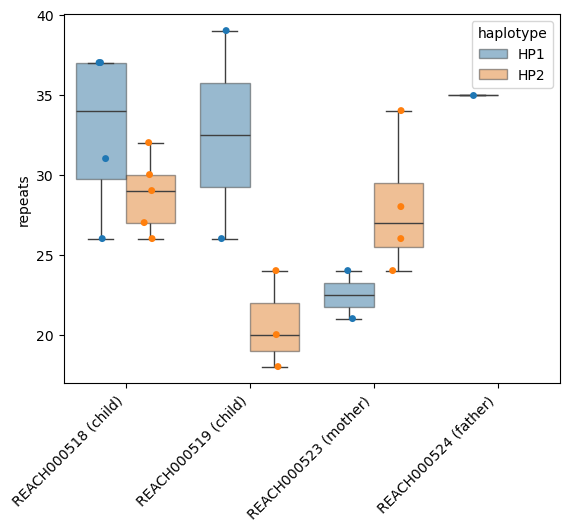

In [13]:
### F0230 family
# REACH000518:
#c1_hp_0 = [14,13]
c1_hp_1 = [35,53,19,52]
c1_hp_2 = [19,29,30,36,21]

# REACH000519:
c2_hp_1 = [18,58]
c2_hp_2 = [-6,2,14]

# REACH000523 (mom):
m_hp_1 = [13,5]
m_hp_2 = [44,19,12,26]

# REACH000524 (dad):
d_hp_1 = [45]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000518 (child)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000519 (child)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000523 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000524 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
display(df_plt_c1)
display(df_plt_c2)
display(df_plt_m)
display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
#fig_name = 'denovo_FX_REACH000519.png'
fig_name = f'{dir_fig}/denovo_FX_REACH000519_repeats.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

,Subject,haplotype,base pair deviation
0,"REACH000510 (proband, F)",HP1,56
1,"REACH000510 (proband, F)",HP1,27
2,"REACH000510 (proband, F)",HP1,9
3,"REACH000510 (proband, F)",HP2,-14
4,"REACH000510 (proband, F)",HP2,46
5,"REACH000510 (proband, F)",HP2,-43
6,"REACH000510 (proband, F)",HP2,27


,Subject,haplotype,base pair deviation
0,"REACH000513 (sibling, F)",HP1,11
1,"REACH000513 (sibling, F)",HP2,31
2,"REACH000513 (sibling, F)",HP2,27
3,"REACH000513 (sibling, F)",HP2,20
4,"REACH000513 (sibling, F)",HP2,0


,Subject,haplotype,base pair deviation
0,REACH000511 (mother),HP1,9
1,REACH000511 (mother),HP2,32
2,REACH000511 (mother),HP2,27
3,REACH000511 (mother),HP2,14


,Subject,haplotype,base pair deviation
0,REACH000512 (father),HP1,28
1,REACH000512 (father),HP1,17
2,REACH000512 (father),HP1,30
3,REACH000512 (father),HP1,9
4,REACH000512 (father),HP1,40
5,REACH000512 (father),HP1,17


,Subject,haplotype,base pair deviation,repeats
0,"REACH000510 (proband, F)",HP1,56,38
1,"REACH000510 (proband, F)",HP1,27,29
2,"REACH000510 (proband, F)",HP1,9,23
3,"REACH000510 (proband, F)",HP2,-14,15
4,"REACH000510 (proband, F)",HP2,46,35
5,"REACH000510 (proband, F)",HP2,-43,5
6,"REACH000510 (proband, F)",HP2,27,29
0,"REACH000513 (sibling, F)",HP1,11,23
1,"REACH000513 (sibling, F)",HP2,31,30
2,"REACH000513 (sibling, F)",HP2,27,29


fragile_x//denovo_FX_REACH000510_repeats.png


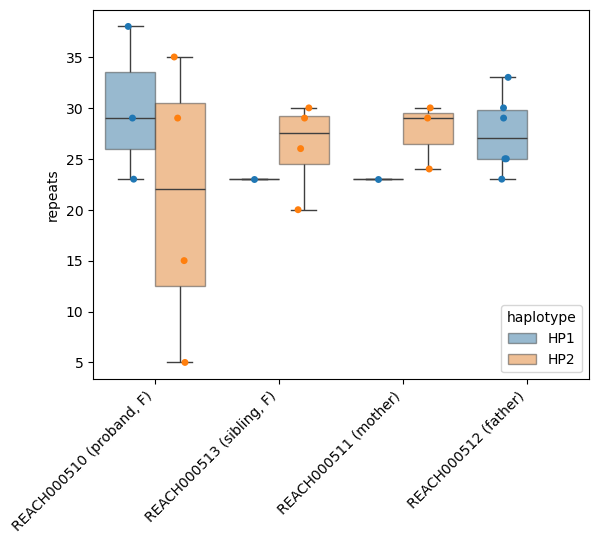

In [14]:
### F0228 family
# REACH000510 (pro):
c1_hp_1 = [56,27,9]
c1_hp_2 = [-14,46,-43,27]

# REACH000511 (mom):
m_hp_1 = [9]
m_hp_2 = [32,27,14]
#9:.:32,27,14

# REACH000512 (dad):
d_hp_1 = [28,17,30,9,40,17]

# REACH000513 (sib):
c2_hp_1 = [11]
c2_hp_2 = [31,27,20,0]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000510 (proband, F)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000513 (sibling, F)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000511 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000512 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
display(df_plt_c1)
display(df_plt_c2)
display(df_plt_m)
display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
fig_name = f'{dir_fig}/denovo_FX_REACH000510_repeats.png'
print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
pd.set_option('display.max_rows', None)
#df_flt_look = df.loc[df.repeats_max>55]
#df_flt_look_fam = df.loc[df.Fam_id.isin(df_flt_look.Fam_id)]
#display(df_flt_look)
#display(df_flt_look_fam)

In [20]:
print(df_flt.shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats>55)].shape)
display(df_flt.loc[(df_flt.sex==2)&(df_flt.max_repeats>55)].shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats==55)].shape)
display(df_flt.loc[(df_flt.sex==2)&(df_flt.max_repeats==55)].shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats>=55)])

(47, 11)


(16, 11)

(19, 11)

(7, 11)

(5, 11)

,Sample_id,HP_1,HP_2,Qual,Fam_id,sex,rel,MAX_HP,max_repeats,Affected,Platform
6,REACH000058,51|51,1.58|1.58,0.97,F0058,1,C,51,61,Yes,PB
9,REACH000441,51|51,1.58|1.58,0.33,F0058,1,C,51,61,No,PB
15,REACH000088,31|34,0.32|0.51,0.99,F0078,1,P,34,55,No,PB
19,REACH000094,34|34,0.51|0.51,0.33,F0081,1,P,34,55,No,PB
27,REACH000154,26|34,0.01|0.51,1,F0125,1,C,34,55,Yes,ONT
42,REACH000214,30|37,0.26|0.70,1,F0152,1,C,37,56,Yes,PB
48,REACH000221,34|37,0.51|0.70,0.81,F0154,1,P,37,56,No,PB
75,REACH000295,36|36,0.64|0.64,0.67,F0176,1,P,36,56,No,PB
77,REACH000315,30|35,0.26|0.57,1,F0181,1,P,35,55,No,PB
103,REACH000416,25|43,-0.06|1.08,1,F0206,1,P,43,58,No,ONT


dist_density_bp_div_FX.png


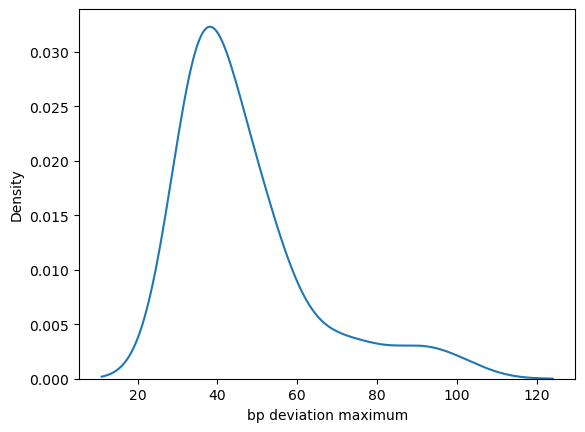

In [7]:
plt.figure()
sb.kdeplot(data=df_flt, x='MAX_HP', common_norm=False)
#sb.displot(data=df_flt, x='MAX_HP', binwidth=3)
#plt.xticks(rotation=45, ha='right')
plt.xlabel('bp deviation maximum')
#plt.title(title)
#plt.ylabel(f'Fraction of LR ({col_lr}) in IL')
fig_name = 'dist_density_bp_div_FX.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()